# Table of Contents
 <p><div class="lev1"><a href="#Derive-scaling"><span class="toc-item-num">1&nbsp;&nbsp;</span>Derive scaling</a></div><div class="lev2"><a href="#Compute-statistics"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Compute statistics</a></div><div class="lev3"><a href="#Decompose-bias-into-its-contributions-from-qvstar-and-omega-(scaling-#3)"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Decompose bias into its contributions from qvstar and omega (scaling #3)</a></div><div class="lev2"><a href="#Decompose-the-variance"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Decompose the variance</a></div><div class="lev3"><a href="#Decompose-Variance-into-its-contributions-from-qvstar-and-omega-(scaling-#3)"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Decompose Variance into its contributions from qvstar and omega (scaling #3)</a></div><div class="lev3"><a href="#Decompose-variance-into-its-contributions-from-T-and-omega-(ignore-variability-in-pressure)"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Decompose variance into its contributions from T and omega (ignore variability in pressure)</a></div><div class="lev1"><a href="#Save-all-variables-in-dataframe"><span class="toc-item-num">2&nbsp;&nbsp;</span>Save all variables in dataframe</a></div>

In [28]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [324]:
%autoreload 2

print("-- loading modules")
print()

import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
import datetime as dt
import time
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *
from thermoConstants import L_v,R_v
from plotMaps import *
from plot1DInvLog import *
from statisticalDistributions import *
from outputResults import *

## Graphical parameters
plt.style.use('/global/homes/b/bfildier/.config/matplotlib/stylelib/jollyjumper.mplstyle')

-- loading modules

Own modules available: ['plot1DInvLog', 'thermoFunctions', 'statisticalDistributions', 'slicingAndSubsetting', 'outputResults', 'thermoConstants', 'plotMaps', 'daskOptions', 'scalingApproximations', 'CAMsettings', 'environmentAndDirectories', 'importingData', 'physicalConstants']


In [130]:
print()
print("-- define global variables")
print()

print("- choosing options:")
compset = 'FSPCAMm_AMIP'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
time_stride = 'day'
resolution = 'dx'
daskarray = False
tracktime = True
dates = ('185005010000','185005020000')

for v in ['compset','experiment','member','subset','time_stride','resolution',\
          'daskarray','dates']:
    print("%s:"%v,getattr(thismodule,v))

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(figdir,exist_ok=True)

# Results output directory
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(resultdir,exist_ok=True)

print()


-- define global variables

- choosing options:
compset: FSPCAMm_AMIP
experiment: piControl
member: r1i1p1
subset: tropics
time_stride: day
resolution: dx
daskarray: False
dates: ('185005010000', '185005020000')



In [138]:
if tracktime:
    t0 = time.time()

In [105]:
print("-- load environment and variables")
print()

historyFilesSettings = getCAMHistoryFilesSettings()

inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

omega_id = 'OMEGA'
omega = getValues(omega_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
pr_id = 'PRECT'
pr = getValues(pr_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
ts_id = 'TS'
ts = getValues(ts_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)


-- load environment and variables

Importing OMEGA from 26 history files between 1850-05-01-00000 and 1850-05-02-00000
Importing PRECT from 26 history files between 1850-05-01-00000 and 1850-05-02-00000
Importing TS from 26 history files between 1850-05-01-00000 and 1850-05-02-00000


In [106]:
## Get longitude, latitude and landmask

print("- load geographic data")

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)
lon2D = da.from_array(lon2D,chunks=lon2D.shape)
lat2D = da.from_array(lat2D,chunks=lat2D.shape)

landmask = fh.variables['landmask']
fh.close()


- load geographic data


In [107]:
print("- load surface pressure")

input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)

ps_varid = 'PS'
ps = getValues(ps_varid,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
pres = computeP(ps)
cn = getArrayType(pres)


- load surface pressure
Importing PS from 26 history files between 1850-05-01-00000 and 1850-05-02-00000


# Derive scaling

In [108]:
print()
print("-- compute (percentile-wise and pointwise) scaling approximation")
print()


-- compute (percentile-wise and pointwise) scaling approximation



In [109]:
%%time
print("compute 2D surfaces of predictor variables")
p_500 = 50000; levdim=1
omega_500 = isobaricSurface(omega,pres,p_ref=p_500,levdim=levdim)
qvstar_s = saturationSpecificHumidity(ts,ps)

compute 2D surfaces of predictor variables
CPU times: user 42.2 ms, sys: 3.98 ms, total: 46.2 ms
Wall time: 44.8 ms


In [110]:
%%time
print("Compute ranks and ranks locations")

n_pts = pr.size
Q_IL = getInvLogRanks(n_pts,fill_last_decade=True)
i_Q = indexOfRank(99.9,Q_IL)
iQ_slice = slice(i_Q-5,i_Q+5)
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),Q_IL)
iQ_min = 8
iQ_max = min(len(Q_IL),41)

# Define reference percentiles and compute percentiles
targetranks = Q_IL[iQ_min:iQ_max]
ranks_ref = Q_IL[:iQ_max]
percentiles = adjustRanks(centers,ranks,ranks_ref)

# Suffix to save figures and results
output_suffix = 'Q%d-Q%d_%s'%(iQ_min,iQ_max,'-'.join(dates))

rank_locations= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,bins,rank_locations)
print()

Compute ranks and ranks locations
0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 
CPU times: user 11.8 ms, sys: 821 µs, total: 12.6 ms
Wall time: 9.46 ms


In [111]:
print("compute sample size in each bin")
N_prQ = sampleSizeAtAllRanks(targetranks,pr,ranks_ref,rank_locations=rank_locations)
print(np.nansum(N_prQ),pr.size)

compute sample size in each bin
1021.0 4608


> Plot sample size in each percentile bin


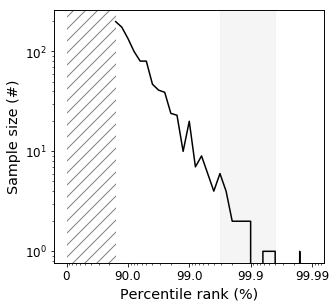

In [112]:
print("> Plot sample size in each percentile bin")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')

# Add zero line
addZeroLine(ax,ranks_ref)

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

subplotRanksILog(ax,ranks_ref,
                 N_prQ,
                 col='k',ltype='-',transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel('Sample size (#)')

plt.savefig(os.path.join(figdir,'sample_size_in_P_bins_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

In [113]:
%%time
print("compute pointwise scaling")
eps, pr_sc_vQ = computeScalingOmegaQAtAllRanks(targetranks,omega_500,qvstar_s,pr,ranks_ref=ranks_ref[iQ_slice],
                                                  bins=bins,rank_locations=rank_locations)
pr_sc_vQ = adjustRanks(pr_sc_vQ,targetranks,ranks_ref)
pr_sc = singleLevelScalingFromOmegaQ(omega_500,qvstar_s,efficiency=eps)
print("eps =",eps)

compute pointwise scaling
eps = 0.000561639762019
CPU times: user 9.98 ms, sys: 0 ns, total: 9.98 ms
Wall time: 9.18 ms


## Compute statistics

In [114]:
print()
print("-- compute statistics")
print()


-- compute statistics



In [115]:
# %%time
print("mean of scaling in pr bins")
pr_sc_prQ = meanXAtAllYRanks(targetranks,pr_sc,pr,ranks_ref,rank_locations=rank_locations)

mean of scaling in pr bins


In [116]:
%%time
print("interquartile and 90% ranges")
ranks_I90 = (5,95)
ranks_IQR = (25,75)

pr_sc_I90 = XPercentilesAtAllYRanks(targetranks,pr_sc,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_sc_IQR = XPercentilesAtAllYRanks(targetranks,pr_sc,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)


interquartile and 90% ranges
CPU times: user 5.9 ms, sys: 3.6 ms, total: 9.5 ms
Wall time: 8.61 ms


> plot PDF with scaling and variability


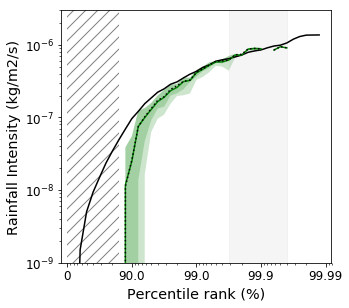

In [117]:
print("> plot PDF with scaling and variability")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')
ax.set_ylim((1e-9,3e-6))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)
# 90% confidence interval for pointwise scaling 2
subplotYShadingRanksILog(ax,ranks_ref,[pr_sc_I90[:,0],pr_sc_IQR[:,1]],col='green',transformX=False)
# Interquartile range for pointwise scaling 2
subplotYShadingRanksILog(ax,ranks_ref,[pr_sc_IQR[:,0],pr_sc_IQR[:,1]],col='green',transformX=False)
# Mean of pointwise scaling 2
subplotRanksILog(ax,ranks_ref,[percentiles,pr_sc_prQ,pr_sc_vQ],col=['k','green','k'],ltype=['-','-',':'],\
                 transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel('Rainfall Intensity (kg/m2/s)')
# ax.set_title(r'$\varepsilon\omega_{500}q_v^\star(T)$')

plt.savefig(os.path.join(figdir,'pdf_P_and_Psc_mean_IQR_I90_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

### Decompose bias into its contributions from qvstar and omega (scaling #3)

In [118]:
print()
print("-- decompose bias into qvstar and omega contributions")
print()


-- decompose bias into qvstar and omega contributions



In [119]:
%%time
print("Q-mean terms")
qvstar_s_prQ = meanXAtAllYRanks(targetranks,qvstar_s,pr,ranks_ref,rank_locations=rank_locations)
omega_500_prQ = meanXAtAllYRanks(targetranks,omega_500,pr,ranks_ref,rank_locations=rank_locations)

Q-mean terms
CPU times: user 8.49 ms, sys: 0 ns, total: 8.49 ms
Wall time: 7.33 ms


In [120]:
%%time
print("Compute bias")
bias_sc = (pr_sc_prQ - pr_sc_vQ)/pr_sc_prQ
print(np.nanmean(bias_sc[iQ_slice]))

Compute bias
-0.00405661607612
CPU times: user 938 µs, sys: 249 µs, total: 1.19 ms
Wall time: 645 µs


In [121]:
%%time
print("covariance term")
cov_qvstar_s_omega_500_prQ = covAtAllYRanks(targetranks,qvstar_s,omega_500,pr,ranks_ref,
                                            rank_locations=rank_locations)

covariance term
CPU times: user 5.64 ms, sys: 340 µs, total: 5.98 ms
Wall time: 5.18 ms


In [122]:
print("normalized contribution")
contribQOmega_bias_covQOmega = cov_qvstar_s_omega_500_prQ/qvstar_s_prQ/omega_500_prQ

normalized contribution


> plot bias and corresponding contributions


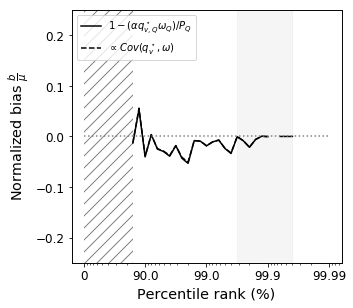

In [123]:
# %%time
print("> plot bias and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.25,.25))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

subplotRanksILog(ax,ranks_ref,
                 bias_sc,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks_ref,
                 contribQOmega_bias_covQOmega,
                 col='k',ltype='--',transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

ax.legend([r'$1-(\alpha q_{v,Q}^\star \omega_Q) / P_Q$',r'$\propto Cov(q_v^\star,\omega)$'],
          loc = 'upper left')

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Normalized bias $\frac{b}{\mu}$')

plt.savefig(os.path.join(figdir,'bias_and_cov_omega_q_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

## Decompose the variance

### Decompose Variance into its contributions from qvstar and omega (scaling #3)

In [124]:
print()
print("-- decompose variance into qvstar and omega contributions")
print()


-- decompose variance into qvstar and omega contributions



In [125]:
%%time 
print("Compute the variance in pr")
var_pr_sc_prQ = varXAtAllYRanks(targetranks,pr_sc,pr,ranks_ref,rank_locations=rank_locations)

Compute the variance in pr
CPU times: user 5.25 ms, sys: 235 µs, total: 5.48 ms
Wall time: 4.65 ms


In [126]:
print("normalized variability")
norm_var_pr_sc_prQ = var_pr_sc_prQ/(pr_sc_prQ**2)
print(np.nanmean(norm_var_pr_sc_prQ[iQ_slice]))

normalized variability
0.00854905320741


In [127]:
%%time
print("compute variability terms")
var_qvstar_s_prQ = varXAtAllYRanks(targetranks,qvstar_s,pr,ranks_ref,rank_locations=rank_locations)
var_omega_500_prQ = varXAtAllYRanks(targetranks,omega_500,pr,ranks_ref,rank_locations=rank_locations)
cov_qvstar_s_omega_500_prQ = covAtAllYRanks(targetranks,qvstar_s,omega_500,pr,ranks_ref,
                                            rank_locations=rank_locations)
cov_qvstar_s_2_omega_500_2_prQ = covAtAllYRanks(targetranks,qvstar_s**2,omega_500**2,pr,ranks_ref,
                                                rank_locations=rank_locations)

compute variability terms
CPU times: user 17.8 ms, sys: 105 µs, total: 17.9 ms
Wall time: 16.6 ms


In [128]:
print("normalized contributions, expanded terms")

# a_v = (eps/gg)**2
# contrib_covX2Y2 = a_v*cov_qvstar_s_2_omega_500_2_prQ/(pr_sc_prQ**2)
# contrib_varX = a_v*(omega_500_prQ**2)*var_qvstar_s_prQ/(pr_sc_prQ**2)
# contrib_varY = a_v*(qvstar_s_prQ**2)*var_omega_500_prQ/(pr_sc_prQ**2)
# contrib_varXvarY = a_v*var_qvstar_s_prQ*var_omega_500_prQ/(pr_sc_prQ**2)
# contrib_cov2XY = -a_v*(cov_qvstar_s_omega_500_prQ**2)/(pr_sc_prQ**2)
# contrib_covXY = -a_v*2*qvstar_s_prQ*omega_500_prQ*cov_qvstar_s_omega_500_prQ/(pr_sc_prQ**2)
contribQOmega_var_covQ2Omega2 = cov_qvstar_s_2_omega_500_2_prQ/((omega_500_prQ*qvstar_s_prQ)**2)
contribQOmega_var_varQ = var_qvstar_s_prQ/(qvstar_s_prQ**2)
contribQOmega_var_varOmega = var_omega_500_prQ/(omega_500_prQ**2)
contribQOmega_var_varQvarOmega = var_qvstar_s_prQ*var_omega_500_prQ/((omega_500_prQ*qvstar_s_prQ)**2)
contribQOmega_var_cov2QOmega = -(cov_qvstar_s_omega_500_prQ**2)/((omega_500_prQ*qvstar_s_prQ)**2)
contribQOmega_var_covQOmega = -2*cov_qvstar_s_omega_500_prQ/(omega_500_prQ*qvstar_s_prQ)
contribQOmega_var_sum = contribQOmega_var_covQ2Omega2 + contribQOmega_var_varQ + contribQOmega_var_varOmega + \
    contribQOmega_var_varQvarOmega + contribQOmega_var_cov2QOmega + contribQOmega_var_covQOmega

print(np.nanmean(contribQOmega_var_covQ2Omega2[iQ_slice]),np.nanmean(contribQOmega_var_varQ[iQ_slice]),
      np.nanmean(contribQOmega_var_varOmega[iQ_slice]),np.nanmean(contribQOmega_var_varQvarOmega[iQ_slice]),
      np.nanmean(contribQOmega_var_cov2QOmega[iQ_slice]),np.nanmean(contribQOmega_var_covQOmega[iQ_slice]),
      np.nanmean(contribQOmega_var_sum[iQ_slice]))

normalized contributions, expanded terms
-0.0235874710388 0.0109614820983 0.00914512610419 0.000114216740423 -9.21547287578e-05 0.0119820645647 0.00852326374005


> plot variance and corresponding contributions


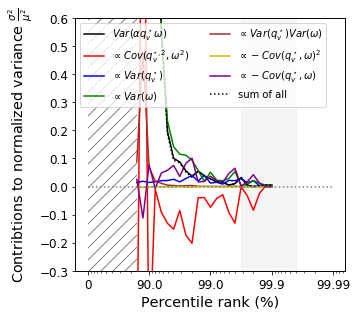

CPU times: user 1.52 s, sys: 51.1 ms, total: 1.58 s
Wall time: 1.56 s


In [129]:
%%time
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.3,.6))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

subplotRanksILog(ax,ranks_ref,
                 norm_var_pr_sc_prQ,
                 col='k',ltype='-',transformX=False)
subplotRanksILog(ax,ranks_ref,
                 [contribQOmega_var_covQ2Omega2,contribQOmega_var_varQ,contribQOmega_var_varOmega,
                  contribQOmega_var_varQvarOmega,contribQOmega_var_cov2QOmega,contribQOmega_var_covQOmega,
                  contribQOmega_var_sum],
                 col=['r','b','g','brown','y','purple','k'],ltype=['-','-','-','-','-','-',':'],transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

leg = ax.legend([r'$Var(\alpha q_v^\star \omega)$',
                 r'$\propto Cov(q_v^{\star,2},\omega^2)$',
                 r'$\propto Var(q_v^\star)$',
                 r'$\propto Var(\omega)$',
                 r'$\propto Var(q_v^\star)Var(\omega)$',
                 r'$\propto -Cov(q_v^\star,\omega)^2$',
                 r'$\propto -Cov(q_v^\star,\omega)$',
                 r'sum of all'],
                 loc='upper left',
                 framealpha=0.8,
                 ncol=2)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contribtions to normalized variance $\frac{\sigma^2}{\mu^2}$')

plt.savefig(os.path.join(figdir,'var_and_contributions_omega_q_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

### Decompose variance into its contributions from T and omega (ignore variability in pressure)

In [92]:
print()
print("-- decompose variance into T and omega contributions")
print()


-- decompose variance into T and omega contributions



In [93]:
print("Q-mean terms")
ts_prQ = meanXAtAllYRanks(targetranks,ts,pr,ranks_ref,rank_locations=rank_locations)

Q-mean terms


In [94]:
%%time
print("compute variability terms")
var_ts_prQ = varXAtAllYRanks(targetranks,ts,pr,ranks_ref,rank_locations=rank_locations)
cov_ts_omega_500_prQ = covAtAllYRanks(targetranks,ts,omega_500,pr,ranks_ref,rank_locations=rank_locations)
cov_ts_omega_500_2_prQ = covAtAllYRanks(targetranks,ts,omega_500**2,pr,ranks_ref,rank_locations=rank_locations)

compute variability terms
CPU times: user 27.3 ms, sys: 0 ns, total: 27.3 ms
Wall time: 26.1 ms


In [95]:
print("normalized contributions, expanded terms")

contribTOmega_var_covTOmega2 = 2*L_v/R_v*cov_ts_omega_500_2_prQ/(ts_prQ*omega_500_prQ)**2
contribTOmega_var_covTOmega = -2*L_v/R_v*cov_ts_omega_500_prQ/((ts_prQ**2)*omega_500_prQ)
contribTOmega_var_varT = ((L_v/R_v)**2)*var_ts_prQ/(ts_prQ**4)
contribTOmega_var_varOmega = var_omega_500_prQ/(omega_500_prQ**2)
contribTOmega_var_sum = contribTOmega_var_covTOmega2+contribTOmega_var_covTOmega+contribTOmega_var_varT+\
    contribTOmega_var_varOmega
all_contribTOmega_var = [contribTOmega_var_covTOmega2,contribTOmega_var_covTOmega,contribTOmega_var_varT,
                    contribTOmega_var_varOmega,contribTOmega_var_sum]
for contrib in all_contribTOmega_var:
    print(np.nanmean(contrib[iQ_slice]),end=' ')
print()

normalized contributions, expanded terms
-0.00125927324081 0.000398086070053 0.00964759209928 0.00875939982415 0.0175458047527 


> plot variance and corresponding contributions


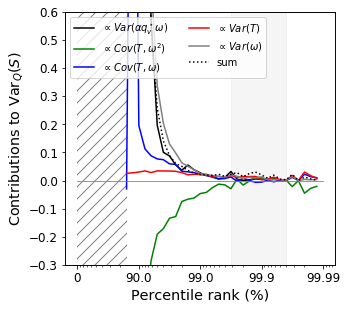

CPU times: user 1.18 s, sys: 51 ms, total: 1.23 s
Wall time: 1.22 s


In [355]:
%%time 
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_ylim((-0.3,0.6))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

# subplotRanksILog(ax,ranks,np.zeros(ranks.shape),ltype=':',col='k')
subplotRanksILog(ax,ranks_ref,
                 norm_var_pr_sc_prQ,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks_ref,
                 all_contribTOmega_var,
                 col=['green','blue','red','grey','k'],ltype=['-','-','-','-',':'],transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contributions to Var$_Q(S)$')
# ax.set_title(r'$S(\omega,T)=\varepsilon\omega_{500}q_v^\star(T)$')

ax.legend([r'$\propto Var(\alpha q_v^\star \omega)$',r'$\propto Cov(T,\omega^2)$',r'$\propto Cov(T,\omega)$',
           r'$\propto Var(T)$',
           r'$\propto Var(\omega)$','sum'],ncol=2,framealpha=0.8,loc='upper left')

plt.savefig(os.path.join(figdir,'var_and_contributions_omega_T_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

# Save all variables in dataframe

In [150]:
print("-- Save results")
import pandas as pd
import re
import pickle

-- Save results


In [99]:
print("find all varnames to save")
vars_out = ['ranks_ref']
vars_out.extend([v for v in locals().keys() if v.endswith('prQ') or v.endswith('vQ')])
vars_out.extend([v for v in locals().keys() if v.startswith('contrib')])

find all varnames to save


In [100]:
print("create result dataframe")
results_df = pd.DataFrame({v:getattr(thismodule,v) for v in vars_out})

create result dataframe


In [101]:
resultfile = 'results_%s.csv'%output_suffix
print("> save results to %s"%resultfile)
results_df.to_csv(os.path.join(resultdir,resultfile))
print()

> save results to results_Q8-Q41_185005010000-185005100000.csv



In [349]:
if tracktime:
    timingfile = 'timing.csv'
    fulltimingfile = os.path.join(resultdir,timingfile)
    t1 = time.time()
    time_elapsed_s = t1-t0
    timing_df = saveTiming(fulltimingfile,output_suffix,pr.size,time_elapsed_s,reset_value=True)

Script successfully terminated in 1:50:28.313670.
> Save timing and size info to /global/u2/b/bfildier/code/dataAnalysis/extreme-rain-predictability-across-scales/results/omega500tsps/FSPCAMm_AMIP/piControl/r1i1p1/tropics/day/dx/timing.csv.
1:50:28.313670
